# 1) Cargamos los datos 📕

In [27]:
import pandas as pd
data = pd.read_csv("data/ohe_customer_dataset.csv", sep=',') 

In [28]:
pd.set_option('display.max_columns', None)
data.head(5)

,transactionFailed,fraudulent,"orderAmount_(9.999, 18.4]","orderAmount_(18.4, 30.0]","orderAmount_(30.0, 39.0]","orderAmount_(39.0, 47.0]","orderAmount_(47.0, 353.0]",orderAmount_desconocido,orderState_failed,orderState_fulfilled,orderState_pending,paymentMethodRegistrationFailure_False,paymentMethodRegistrationFailure_True,paymentMethodType_apple pay,paymentMethodType_bitcoin,paymentMethodType_card,paymentMethodType_paypal,paymentMethodProvider_American Express,paymentMethodProvider_Diners Club / Carte Blanche,paymentMethodProvider_Discover,paymentMethodProvider_JCB 15 digit,paymentMethodProvider_JCB 16 digit,paymentMethodProvider_Maestro,paymentMethodProvider_Mastercard,paymentMethodProvider_VISA 13 digit,paymentMethodProvider_VISA 16 digit,paymentMethodProvider_Voyager,paymentMethodIssuer_Bastion Banks,paymentMethodIssuer_Bulwark Trust Corp.,paymentMethodIssuer_Citizens First Banks,paymentMethodIssuer_Fountain Financial Inc.,paymentMethodIssuer_Grand Credit Corporation,paymentMethodIssuer_Her Majesty Trust,paymentMethodIssuer_His Majesty Bank Corp.,paymentMethodIssuer_Rose Bancshares,paymentMethodIssuer_Solace Banks,paymentMethodIssuer_Vertex Bancorp,paymentMethodIssuer_weird,"transactionAmount_(9.999, 21.0]","transactionAmount_(21.0, 34.0]","transactionAmount_(34.0, 45.0]","transactionAmount_(45.0, 353.0]",emailDomain_biz,emailDomain_com,emailDomain_info,emailDomain_net,emailDomain_org,emailDomain_weird,emailProvider_gmail,emailProvider_hotmail,emailProvider_other,emailProvider_weird,emailProvider_yahoo,customerIPAddressSimplified_digits_and_letters,customerIPAddressSimplified_only_letters,sameCity_no,sameCity_unknown,sameCity_yes
0,False,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1
1,False,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0
2,False,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0
3,False,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0
4,True,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0


In [29]:
pd.reset_option('display.max_columns')

In [30]:
# Para este momento me di cuenta que nunca habia borrado la columna email
# Procedi a borrarla y volver a correr todos los notebook (con el riesgo de stroke que eso conlleva)
# Pero todo salio bien 🏌🏻 creo...
data.columns

Index(['transactionFailed', 'fraudulent', 'orderAmount_(9.999, 18.4]',
       'orderAmount_(18.4, 30.0]', 'orderAmount_(30.0, 39.0]',
       'orderAmount_(39.0, 47.0]', 'orderAmount_(47.0, 353.0]',
       'orderAmount_desconocido', 'orderState_failed', 'orderState_fulfilled',
       'orderState_pending', 'paymentMethodRegistrationFailure_False',
       'paymentMethodRegistrationFailure_True', 'paymentMethodType_apple pay',
       'paymentMethodType_bitcoin', 'paymentMethodType_card',
       'paymentMethodType_paypal', 'paymentMethodProvider_American Express',
       'paymentMethodProvider_Diners Club / Carte Blanche',
       'paymentMethodProvider_Discover', 'paymentMethodProvider_JCB 15 digit',
       'paymentMethodProvider_JCB 16 digit', 'paymentMethodProvider_Maestro',
       'paymentMethodProvider_Mastercard',
       'paymentMethodProvider_VISA 13 digit',
       'paymentMethodProvider_VISA 16 digit', 'paymentMethodProvider_Voyager',
       'paymentMethodIssuer_Bastion Banks',
     

In [31]:
import mlflow.sklearn

#### Le asignamos un nombre al experimento

In [32]:
mlflow.set_experiment(experiment_name="proyecto_bootcamp_final")
mlflow.log_param("Tamaño dataset", data.shape)
print(data.shape)

(623, 58)


# 3) Clasificación 🎯


## 3.1) Separación de X de Y, y luego TR de TS (rutina):

In [33]:
data_x = data.drop('fraudulent', axis=1)
data_y = data['fraudulent']

In [34]:
data_x = data_x.values
data_y = data_y.values

In [35]:
# Consideren `test_size=0.3`
TEST_SIZE = 0.3
mlflow.log_param("Porcentaje de test", TEST_SIZE)

0.3

In [36]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=TEST_SIZE)

## 3.2) Creación del modelo predictivo

In [37]:
# Consideren `n_estimators=500` y `random_state=99`
NUM_ESTIMATORS = 500
RANDOM_STATE = 99
mlflow.log_param("Número de estimadores", NUM_ESTIMATORS)
mlflow.log_param("Valor semilla", RANDOM_STATE)

99

In [38]:
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier(n_estimators = NUM_ESTIMATORS, random_state = RANDOM_STATE)

In [39]:
rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=99)

## 3.4) Matriz de confusión

### a) Valores absolutos:

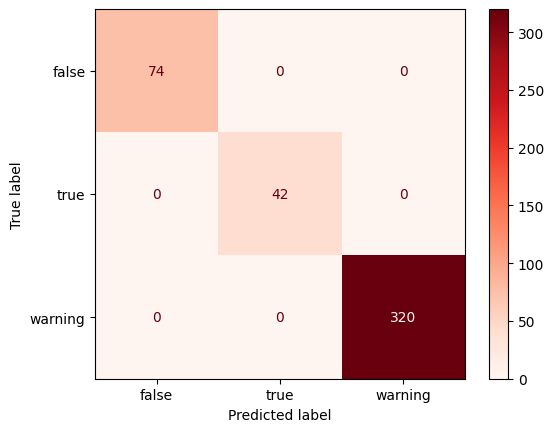

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    rf, x_train, y_train,
    display_labels=['false','true', 'warning'],
    cmap='Reds',
    )

In [41]:
# Resultado de Carlos
# False 78
# True 44
# Warning 314

### e) ¡Importante! Elección de un punto de corte

*Aclaración:* Justo todos los pasos que hacíamos de acá en adelante, están pensados para una clasificación binaria.
<br>Para este caso que es multiclase, no tiene sentido, *por eso no los hacemos.*

# 4) Guardar un modelo

In [42]:
import pickle

filename = 'data/modelo_proyecto_final.pkl'
pickle.dump(rf, open(filename, 'wb'))

In [43]:
# Lo cargamos para ver si funciona
rf_loaded = pickle.load(open(filename, 'rb'))

In [44]:
mlflow.sklearn.log_model(rf, "modelo_proyecto_final")

# 9) Validacion

In [45]:
# En training
pred_tr=rf.predict(x_train)

# En testing
pred_ts=rf.predict(x_test)

## 9.1) Validamos Training

In [46]:
df_val_tr=pd.DataFrame({'y_train':y_train, 'pred_tr':pred_tr})

# ¿cuántos aciertos?
sum(df_val_tr.y_train==df_val_tr.pred_tr)/len(df_val_tr)

1.0

In [47]:
from sklearn.metrics import accuracy_score

In [48]:
accuracy_train = accuracy_score(df_val_tr.y_train, df_val_tr.pred_tr, normalize=True)
print(accuracy_train)

1.0


In [49]:
mlflow.log_metric("Accuracy en Train", accuracy_train)

## 9.2) Validamos Testing

In [50]:
df_val_ts=pd.DataFrame({'y_test':y_test, 'pred_ts':pred_ts})

In [51]:
# ¿cuántos aciertos?
accuracy_test = accuracy_score(df_val_ts.y_test, df_val_ts.pred_ts, normalize=True)
print(accuracy_test)

0.9144385026737968


In [52]:
mlflow.log_metric("Accuracy en Test", accuracy_test)